# **COMPUTER VISION ASSIGNMENT**

In [1]:
# import packages
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential, Model # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D # type: ignore

import warnings
warnings.filterwarnings("ignore")

2023-05-10 07:09:06.349453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-10 07:09:06.349494: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load the Data

In [2]:
import numpy as np


# Load the data using np.load
data = np.load('training_images_full.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

# Load the data that only has a subset of annotations using np.load
data = np.load('training_images_subset.npz', allow_pickle=True)

# Extract the images
images_subset = data['images']
# and the data points
pts_subset = data['points']

print(images_subset.shape, pts_subset.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']
print(example_images.shape)

(1425, 256, 256, 3) (1425, 44, 2)
(1386, 256, 256, 3) (1386, 5, 2)
(554, 256, 256, 3)
(6, 256, 256, 3)


## Data Visualization

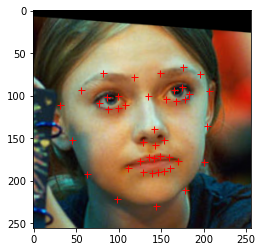

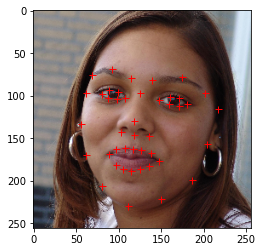

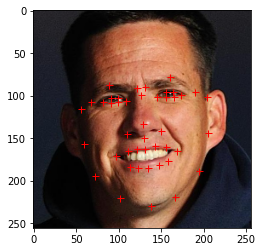

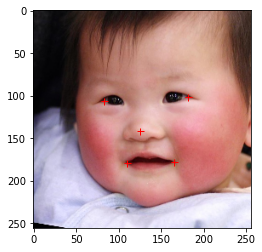

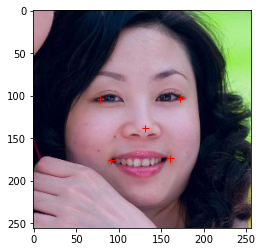

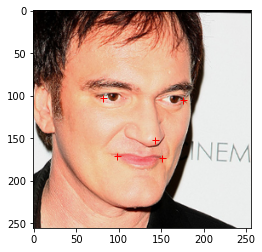

In [3]:
def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r', ms=7)
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images_subset[idx, ...], pts_subset[idx, ...])

## Extracting Subset of Points from Full Set.

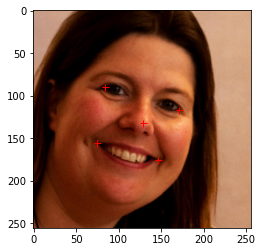

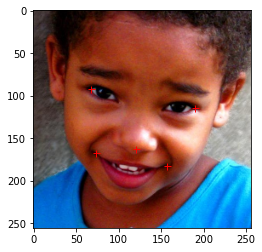

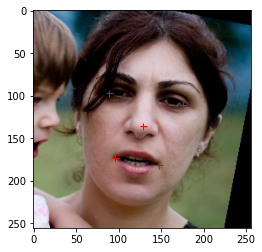

In [4]:
def extract_subset_of_points(pts):
  indices = (20, 29, 16, 32, 38)
  if len(pts.shape) == 3:
    return pts[:, indices, :]
  elif len(pts.shape) == 2:
    return pts[indices, :]


for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], extract_subset_of_points(pts[idx, ...]))

## Calculating Prediction Error.

In [5]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

##  Exporting Results to CSV

In [6]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==44*2, 'wrong number of points provided. There should be 34 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

## Function Definitions

In [70]:
import cv2
import numpy as np
from cv2 import xfeatures2d

'''
Image processing
'''

# Image preprocessing
def preprocess_image(image, target_size=(128, 128)):
    resized_image = cv2.resize(image, target_size)
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    return gray_image

def preprocess_images(images, target_size=(128, 128)):
    return np.array([preprocess_image(image, target_size) for image in images])


'''
Feature Selection
'''
import cv2

def extract_sift_features(image, num_keypoints=200, max_keypoints=100):
    # Create SIFT object
    sift = cv2.SIFT_create(nfeatures=num_keypoints)

    # Detect and compute keypoints and descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Sort keypoints by response and keep only the top 'max_keypoints'
    keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)[:max_keypoints]

    # Recalculate descriptors for the selected keypoints
    _, descriptors = sift.compute(image, keypoints)

    # Normalize the descriptors
    if descriptors is not None:
        descriptors = (descriptors - np.mean(descriptors, axis=0)) / np.std(descriptors, axis=0)
        
        # Pad descriptors with zeros if needed
        if descriptors.shape[0] < max_keypoints:
            padding = np.zeros((max_keypoints - descriptors.shape[0], descriptors.shape[1]))
            descriptors = np.vstack((descriptors, padding))
    
    # Flatten and concatenate the descriptors
    feature_vector = descriptors.flatten()

    return feature_vector



def extract_brief_features(image, num_keypoints=200, max_keypoints=100):
    # Create FAST object for keypoints detection
    fast = cv2.FastFeatureDetector_create()
    keypoints = fast.detect(image, None)

    # Create BRIEF object
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

    # Compute keypoints and descriptors
    keypoints, descriptors = brief.compute(image, keypoints)
    if descriptors is None:
        return np.zeros((max_keypoints * 32,))
    descriptors = descriptors[:max_keypoints, :]
    padded_descriptors = np.zeros((max_keypoints, 32))
    padded_descriptors[:descriptors.shape[0], :descriptors.shape[1]] = descriptors
    return padded_descriptors.flatten()


'''
Model Training
'''
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def train_naive_bayes_models(features, target_points):
    num_landmarks = target_points.shape[1]
    num_coords = target_points.shape[2]
    models = []

    for landmark_idx in range(num_landmarks):
        for coord_idx in range(num_coords):
            model = GaussianNB()
            model.fit(features, target_points[:, landmark_idx, coord_idx].astype(int))
            models.append(model)

    return models


'''
Performance Metrics
'''
# Function to evaluate the models using Mean Squared Error
def evaluate_models(models, features, target_points):
    num_landmarks = target_points.shape[1]
    num_coords = target_points.shape[2]
    mse = 0

    for landmark_idx in range(num_landmarks):
        for coord_idx in range(num_coords):
            model_idx = landmark_idx * num_coords + coord_idx
            model = models[model_idx]
            predictions = model.predict(features)
            mse += mean_squared_error(target_points[:, landmark_idx, coord_idx], predictions)

    return mse / (num_landmarks * num_coords)

## Image Preprocessing

In [63]:
train_images_preprocessed = preprocess_images(images)
train_images_subset_preprocessed = preprocess_images(images_subset)
test_images_preprocessed = preprocess_images(test_images)

## Feature extraction:

### Using BIEF Extractor

In [64]:
# BRIEF feature extraction
train_features_brief = np.array([extract_brief_features(image) for image in train_images_preprocessed])
train_features_brief_subset = np.array([extract_brief_features(image) for image in train_images_subset_preprocessed])

test_features_brief = np.array([extract_brief_features(image) for image in test_images_preprocessed])

### Using ORB Extractor

In [71]:
train_features_sift = np.array([extract_sift_features(image) for image in train_images_preprocessed])
train_features_sift_subset = np.array([extract_sift_features(image) for image in train_images_subset_preprocessed])

test_features_sift = np.array([extract_sift_features(image) for image in test_images_preprocessed])


In [72]:
print("BRIEF features shape:", train_features_brief.shape)
print("SIFT features shape:", train_features_sift.shape)

BRIEF features shape: (1425, 3200)
SIFT features shape: (1425, 12800)


## Build and train the model (Random Forest Classifier):

### BRIEF-Based Model

In [29]:
# Train Naive Bayes models
nb_models_brief_full = train_naive_bayes_models(train_features_brief, pts)
nb_models_brief_subset = train_naive_bayes_models(train_features_brief_subset, pts_subset)


### ORB-Based Model

In [73]:
nb_models_sift_full = train_naive_bayes_models(train_features_sift, pts)
nb_models_sift_subset = train_naive_bayes_models(train_features_sift_subset, pts_subset)

## Testing the Models

In [74]:
def predict_naive_bayes_models(models, features):
    num_landmarks = len(models) // 2
    predictions = []

    for i in range(num_landmarks):
        x_pred = models[2 * i].predict(features)
        y_pred = models[2 * i + 1].predict(features)
        coord_pred = np.vstack((x_pred, y_pred)).T
        predictions.append(coord_pred)

    return np.array(predictions).transpose(1, 0, 2)

# Make predictions on test data (full features)
test_predictions_brief_full = predict_naive_bayes_models(nb_models_brief_full, test_features_brief)
test_predictions_sift_full = predict_naive_bayes_models(nb_models_sift_full, test_features_sift)

# Make predictions on the test data (subset features)
test_predictions_brief_subset = predict_naive_bayes_models(nb_models_brief_subset, test_features_brief)
test_predictions_sitf_subset = predict_naive_bayes_models(nb_models_sift_subset, test_features_sift)

## Model Evaluation

In [ ]:
# Euclidean Distance
# Calculate the Euclidean distances for the validation sets
distances_full_brief = euclid_dist(test_predictions_brief_full, pts)
distances_subset_brief = euclid_dist(test_predictions_sift_full, pts)

distances_subset_sift = euclid_dist(test_predictions_brief_subset, pts)
distances_subset_sift = euclid_dist(test_predictions_sitf_subset, pts)

# Calculate the mean and standard deviation of the distances for both datasets
mean_dist_full = np.mean(distances_full_brief)
std_dist_full = np.std(distances_full_brief)
errors_full = np.sum(distances_full_brief)

mean_dist_subset = np.mean(distances_subset_brief)
std_dist_subset = np.std(distances_subset_brief)
errors_subset = np.sum(distances_subset_brief)

In [82]:
pts.shape

(1425, 44, 2)

In [75]:
# Evaluate the models using Mean Squared Error on the full test set
mse_brief_full = evaluate_models(nb_models_brief_full, train_features_brief, pts)
mse_sift_full = evaluate_models(nb_models_sift_full, train_features_sift, pts)

# Evaluate the model using Mean Sqaured Error on the subset test set
mse_brief_subset = evaluate_models(nb_models_brief_subset, train_features_brief_subset, pts_subset)
mse_sift_subset = evaluate_models(nb_models_sift_subset, train_features_sift_subset, pts_subset)

# use the euclidean function


In [77]:
print(f"Mean Squared Error (BRIEF, full): {mse_brief_full:.2f}")
print(f"Mean Squared Error (SIFT, full): {mse_sift_full:.2f}")

print(f"Mean Squared Error (BRIEF, subset): {mse_brief_subset:.2f}")
print(f"Mean Squared Error (SIFT, subset): {mse_sift_subset:.2f}")

Mean Squared Error (BRIEF, full): 46.15
Mean Squared Error (SIFT, full): 10.41
Mean Squared Error (BRIEF, subset): 42.88
Mean Squared Error (SIFT, subset): 5.95


## Visualize Predictions

In [84]:
def visualize_predictions(images, predictions, title_prefix="", num_images=5):
    for idx in range(min(num_images, len(images))):
        title = f"{title_prefix} - Image {idx + 1}"
        visualise_pts(images[idx], predictions[idx], title=title)
        plt.show()

# Visualize the predicted points for test data (full features)
visualize_predictions(test_images_preprocessed, test_predictions_brief_full, title_prefix="BRIEF (Full)")
visualize_predictions(test_images_preprocessed, test_predictions_sift_full, title_prefix="SIFT (Full)")

# Visualize the predicted points for test data (subset features)
visualize_predictions(test_images_preprocessed, test_predictions_brief_subset, title_prefix="BRIEF (Subset)")
visualize_predictions(test_images_preprocessed, test_predictions_sitf_subset, title_prefix="SIFT (Subset)")


TypeError: visualise_pts() got an unexpected keyword argument 'title'